In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from DataProcTools.DataCleaning import MissingValues
from dataprep.clean import clean_country
from scipy import stats


### Loading the Dataset and Exploring

In [2]:
dataset = pd.read_csv('./data/athlete_events.csv')

# Initial dataset info before imputation
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


# Filling The Gap : imputing missing values
### Steps take to impute the data ( broken down by cell ):
Note that all the actual function implementation are done in a separate python file and the methods are called here. Please refer to that file to look at the implementation
- We first stat by describing our data to see which columns have null values and we determine that Age, Height, Weight, and Medals all have null values.
- The next step is to find the percentages of these null values in order to apply a proper imputation technique.
- We Learn that Age has 3% missing values, Height & Weight have 22% and Medals a whopping 85% missing rate
- The Age, Height and Weight are most likely MACR data due to issue with data gathering of the dataset
- The Medal is MNAR because most people that enter the olympics don't win a medal

In [3]:
missingValuesInfo = MissingValues.get_nan_values_percentage(dataset)
print(dataset.describe())
print()
print("Missing values Percentages: ", missingValuesInfo)

                  ID            Age         Height         Weight  \
count  271116.000000  261642.000000  210945.000000  208241.000000   
mean    68248.954396      25.556898     175.338970      70.702393   
std     39022.286345       6.393561      10.518462      14.348020   
min         1.000000      10.000000     127.000000      25.000000   
25%     34643.000000      21.000000     168.000000      60.000000   
50%     68205.000000      24.000000     175.000000      70.000000   
75%    102097.250000      28.000000     183.000000      79.000000   
max    135571.000000      97.000000     226.000000     214.000000   

                Year  
count  271116.000000  
mean     1978.378480  
std        29.877632  
min      1896.000000  
25%      1960.000000  
50%      1988.000000  
75%      2002.000000  
max      2016.000000  

Missing values Percentages:  {'Age': 3.494, 'Height': 22.194, 'Weight': 23.191, 'Medal': 85.326}


- The imputations techniques for each column is as follows:
- Age: Frequent Category Imputation where we replace the Ages with the mode and substitue the nulls for that ( this is because the null value are less than 5% range )
- Height, Weight: We fill those columns up using Multivariate Imputation that is inferred from the average Height and Weight per NOC ( country ) and we substitue this data in.
- Medals: Arbitrary Value Imputation was used where we just replace each occurance of 'NaN' with 'No_Medal' to indicate that no medal was won. This is possible since the data isNOT missing at random.
- We display that dataset info and head after imputation
- All implementations of this are in the Missing_Values.py file in the DataProc folder
- We didn't remove the outliers because Dr Nada send an email allowing us to skip this step

In [4]:
# Average age per NOC ( country ) for every team entry
dataset[['Age','NOC']].groupby('NOC').Age.apply(lambda x: x.mode())

# Get average height and weight based & groupby NOC
average_height = dataset[['Height','NOC']].groupby('NOC').mean()
average_weight = dataset[['Weight','NOC']].groupby('NOC').mean()

# Get average age & store as float64
average_age = dataset['Age'].mode().loc[0]

MissingValues.arbitrary_value_imputer(dataset, 'Age', average_age)
MissingValues.arbitrary_value_imputer(dataset, 'Medal', 'no_medal')
MissingValues.height_imputer(dataset, average_height)
MissingValues.weight_imputer(dataset, average_weight)

In [5]:
# Imputed dataset ( outliers still present )
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     271116 non-null  float64
 4   Height  271116 non-null  float64
 5   Weight  271116 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   271116 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.000000,80.000000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,no_medal
1,2,A Lamusi,M,23.0,170.000000,60.000000,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,no_medal
2,3,Gunnar Nielsen Aaby,M,24.0,179.200997,73.837507,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,no_medal
3,4,Edgar Lindenau Aabye,M,34.0,179.200997,73.837507,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.000000,82.000000,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,no_medal


### Handling Outliers
We remove the outliers by calculating the IQR score for Age, Height, Weight (numerical type data)

In [6]:
dataset_o1 = dataset

Q1 = dataset_o1.quantile(0.25)
Q3 = dataset_o1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

ID        67454.25
Age           6.00
Height       10.00
Weight       12.00
Year         42.00
dtype: float64


In [7]:
print(dataset_o1 < (Q1 - 1.5 * IQR)) or (dataset_o1 > (Q3 + 1.5 * IQR))

/tmp/ipykernel_3683/55998574.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  print(dataset_o1 < (Q1 - 1.5 * IQR)) or (dataset_o1 > (Q3 + 1.5 * IQR))


          Age   City  Event  Games  Height     ID  Medal    NOC   Name  \
0       False  False  False  False   False  False  False  False  False   
1       False  False  False  False   False  False  False  False  False   
2       False  False  False  False   False  False  False  False  False   
3       False  False  False  False   False  False  False  False  False   
4       False  False  False  False   False  False  False  False  False   
...       ...    ...    ...    ...     ...    ...    ...    ...    ...   
271111  False  False  False  False   False  False  False  False  False   
271112  False  False  False  False   False  False  False  False  False   
271113  False  False  False  False   False  False  False  False  False   
271114  False  False  False  False   False  False  False  False  False   
271115  False  False  False  False   False  False  False  False  False   

        Season    Sex  Sport   Team  Weight   Year  
0        False  False  False  False   False  False  
1    

/tmp/ipykernel_3683/55998574.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  print(dataset_o1 < (Q1 - 1.5 * IQR)) or (dataset_o1 > (Q3 + 1.5 * IQR))


,Age,City,Event,Games,Height,ID,Medal,NOC,Name,Season,Sex,Sport,Team,Weight,Year
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
271112,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
271113,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
271114,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [8]:
dataset_cleared_iqr = dataset_o1[~((dataset_o1 < (Q1 - 1.5 * IQR)) |(dataset_o1 > (Q3 + 1.5 * IQR))).any(axis=1)]
dataset_cleared_iqr

/tmp/ipykernel_3683/2557827401.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  dataset_cleared_iqr = dataset_o1[~((dataset_o1 < (Q1 - 1.5 * IQR)) |(dataset_o1 > (Q3 + 1.5 * IQR))).any(axis=1)]


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.000000,80.000000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,no_medal
1,2,A Lamusi,M,23.0,170.000000,60.000000,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,no_medal
2,3,Gunnar Nielsen Aaby,M,24.0,179.200997,73.837507,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,no_medal
3,4,Edgar Lindenau Aabye,M,34.0,179.200997,73.837507,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.000000,82.000000,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,no_medal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271109,135567,Aleksandr Viktorovich Zyuzin,M,28.0,183.000000,72.000000,Russia,RUS,2004 Summer,2004,Summer,Athina,Rowing,Rowing Men's Lightweight Coxless Fours,no_medal
271110,135568,Olga Igorevna Zyuzkova,F,33.0,171.000000,69.000000,Belarus,BLR,2016 Summer,2016,Summer,Rio de Janeiro,Basketball,Basketball Women's Basketball,no_medal
271111,135569,Andrzej ya,M,29.0,179.000000,89.000000,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,no_medal
271112,135570,Piotr ya,M,27.0,176.000000,59.000000,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",no_medal


# Research Questions Explored Below

### Question 1: Relationship between obesity rates in participants and NOC ( country )

#### Steps to get to reach an answer:
- We create a dataset with country ( NOC ), and other elements needed for BMI & BF formula calculations
- We create a gender splitting functions that shows data either for Males / Females
- We create a BMI calculating lambda function with the formula (weight / height^2)
- We create a BodyFat lambda function with the formula ( (1.2 x BMI) + (0.23 x Age) - 16.2 {if female it's 5.4} )
- We separate the male and female dataframes
- We apply the functions to both males and females then display resulting dataframes descendingly

In [9]:
# dataframe with values needed
avg_shwn_df = dataset[['NOC','Sex','Height','Weight','Age']]

# Function to return dataset with only males / females based on input
gender_split = lambda df:(df[df.Sex=='M'],df[df.Sex=='F'])

# calculating BMI for males / females
calc_BMI = lambda W,H : 10000*W/H**2
calc_body_fat = lambda r : 1.20*r.BMI + (0.23*r.Age) - (16.2 if r.Sex=='M' else 5.4)

    
# splitting & calc BMI   
males_df,females_df = gender_split(avg_shwn_df)
males_df['BMI'] = calc_BMI(avg_shwn_df['Weight'],avg_shwn_df['Height'] )
females_df['BMI'] = calc_BMI(avg_shwn_df['Weight'],avg_shwn_df['Height'] )


# Calc AvgBodyFat Percentage
males_df['AvgBF%'] = males_df.apply(calc_body_fat,axis=1)
females_df['AvgBF%'] = females_df.apply(calc_body_fat,axis=1)

# Displaying outputs
print("Male Average")
display(males_df.groupby('NOC').mean().sort_values('AvgBF%',ascending=False))
print("Female Average")
display(females_df.groupby('NOC').mean().sort_values('AvgBF%',ascending=False))

Male Average


,Height,Weight,Age,BMI,AvgBF%
NOC,,,,,
NRU,169.309272,92.727273,23.636364,31.796785,27.392506
KIR,168.625000,84.750000,22.875000,29.690906,24.690337
MNE,188.758621,94.706897,27.931034,26.537865,22.069576
ASA,178.933832,84.335003,27.933333,26.299737,21.784351
COK,173.525125,79.944792,23.458333,26.745295,21.289771
...,...,...,...,...,...
ERI,172.897459,61.027704,24.378378,20.393390,13.879096
ETH,173.297290,61.046373,24.632867,20.317711,13.846812
BDI,175.560000,61.160000,26.360000,19.823204,13.650645


Female Average


,Height,Weight,Age,BMI,AvgBF%
NOC,,,,,
NRU,167.500000,113.000000,22.500000,40.547977,48.432573
SAM,172.716916,83.959377,26.583333,28.406527,34.801999
ASA,169.743000,77.262501,24.142857,26.886397,32.416534
BOH,179.200997,73.837507,35.000000,22.993029,30.241635
COK,169.500000,72.812500,21.937500,25.492040,30.236074
...,...,...,...,...,...
MTN,167.400000,54.200000,19.400000,19.368203,22.303844
MDV,160.100083,49.653126,17.916667,19.292480,21.871809
ETH,163.230446,48.585190,23.195652,18.212210,21.789652


#### Plotting Average Height, Weight, Body Fat for males & females
we're printing a histogram for the heights of makes and females. The first 3 refer to males and the later 3 refer to the females

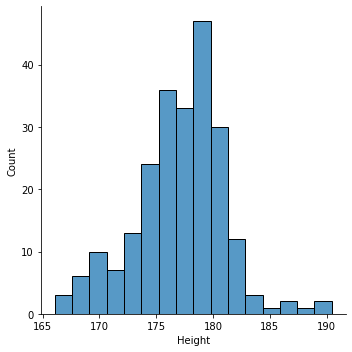

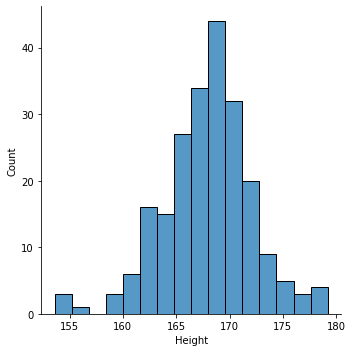

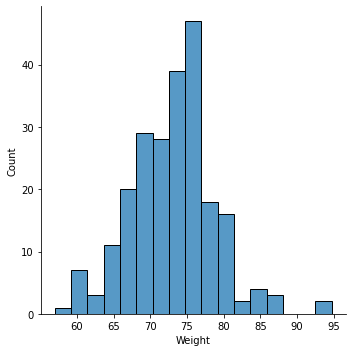

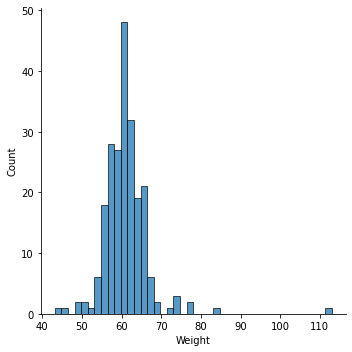

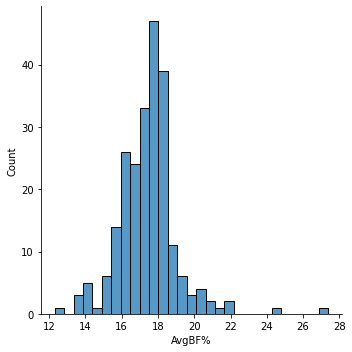

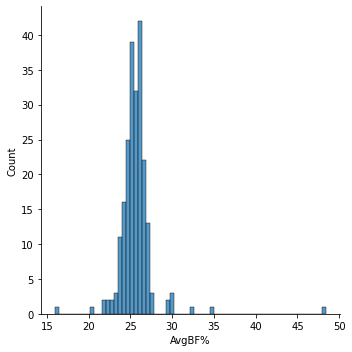

In [10]:
chart_m = males_df.groupby('NOC').mean().sort_values('AvgBF%',ascending=False)
chart_f = females_df.groupby('NOC').mean().sort_values('AvgBF%',ascending=False)
# Plot Average Height, Weight, BodyFat
for col in ['Height', 'Weight', 'AvgBF%']:
    sns.displot(chart_m[col])
    sns.displot(chart_f[col])

### Question 2: What is the the ration of men to women as well as the top 10 most popular sports for men and women ?
#### Steps taken to reach the answer:
- We first create a summerData dataframe and use it for getting the ration of men vs women
    - We chose to do this instead of using both summer and winter data because prior to 1996 all of the games were performed    sequentially but this changed to the 4 year cycle that we know today and in the visualizations causes a weird up and down behaviour the gives a wrong impression of the data. We decided to plot both summer and winter and found out from the plot that more games were held in the summer and that the summer data SPECIFICALLY for this part of the question was more descripitive as the graph as more variation and ups and downs, so we chose to omit the winter data and only use the summer data. It is to be noted though that both winter and summer data show the same general trend. We only did this for ratio calculation but not for the top 10 since it wasn't needed.
- We then grouped the male female data by year and sex, get the size of it and then plot it using sns.lineplot
- to get the data for top 10 games, we use the normal dataset that is filtered based on sex so we can get male/female games and stored in a player male female dataframe.
- we then take this dataframe and group all the results by their size and sort descendingly and display the first 10.
- we display the result below for males and females in a tabular format as a panada series

#### We're also plotting the results as a barplot below. The plots are self descriptive

Mens Top 10 games


/home/adam/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


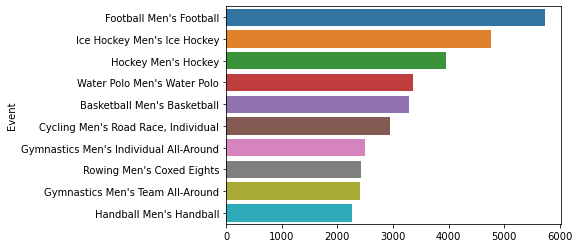

/home/adam/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Womens Top 10 games


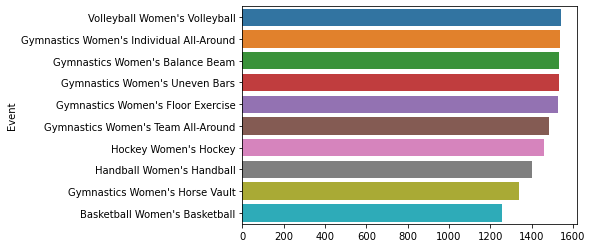

Ratio of Men to Women


<AxesSubplot:xlabel='Year'>

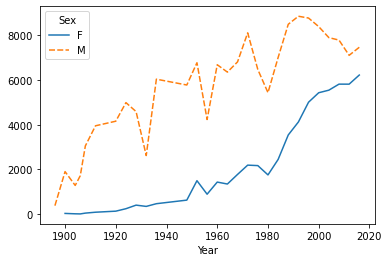

In [11]:
# Summer dataframe init
summer_df = dataset[dataset['Season'] == 'Summer']

# Function to calculate ratio of men to women
def ratio_men_women(dataset):
    mf_summer = dataset.groupby(['Year', 'Sex']).size().unstack()
    mf_chart = sns.lineplot(data=mf_summer)
    return mf_chart

# Function to find top 10 events by gender
def events_by_gender(dataset, sex):
    player_mf = dataset[dataset['Sex'] == sex]
    chart_mf = player_mf.groupby('Event').size().sort_values(ascending= False).head(10)
    return chart_mf

# Display & output of functions
print('Mens Top 10 games')
male_top_10= events_by_gender(dataset, 'M')
sns.barplot(male_top_10.values, male_top_10.index)
plt.legend([],[], frameon=False) # removes legend
plt.show()

print('Womens Top 10 games')
female_top_10= events_by_gender(dataset, 'F')
sns.barplot(female_top_10.values, female_top_10.index)
plt.legend([],[], frameon=False) # removes legend
plt.show()

print('Ratio of Men to Women')
ratio_men_women(summer_df)





## Milestone_2: Noc_Regions Integration:

In [12]:
noc_df = pd.read_csv('./data/noc_regions.csv')

display(noc_df.info())
display(noc_df.head(10))
noc_df[noc_df['region'].isna()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-null    object
 1   region  227 non-null    object
 2   notes   21 non-null     object
dtypes: object(3)
memory usage: 5.5+ KB


None

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN
5,ANG,Angola,NaN
6,ANT,Antigua,Antigua and Barbuda
7,ANZ,Australia,Australasia
8,ARG,Argentina,NaN
9,ARM,Armenia,NaN


,NOC,region,notes
168,ROT,NaN,Refugee Olympic Team
208,TUV,NaN,Tuvalu
213,UNK,NaN,Unknown


#### Handling NaN Values in NOC csv file
The NOC CSV file has a 91% missing percentage for the notes entries. This data is MNAR since it's referring to a team that is formed based on a province / sub country within the main region it belongs to ( hong_kong & china for example ). We'll just replace all the missing values with a static value saying ( region_is_noc ) to show that the NOC is referring to the entire region for that entry and not a province / sub team. We'll do this using the arbitrary value substitution technique like we did above for medals.
###### Notes:
We'll fill the NaN values in region with their corresponding Notes since they're referring to either what region the team is from or if they're an independant team (IOC Refugee Olympic Team ) 

In [13]:
# Percentage of missing NaN values:
missingValues = MissingValues.get_nan_values_percentage(noc_df)
missingValues

{'region': 1.304, 'notes': 90.87}

In [14]:
# Notes column imputation (implementation in missingValues.py file)
MissingValues.arbitrary_value_imputer(noc_df, 'notes', 'region_is_noc')

# Imputing region based on notes
MissingValues.region_imputer(noc_df, 'notes', 'region')

In [15]:
# Merging Noc_regions.csv with athlete_events.csv 
# Note: We drop regions since NOC has more regions that aren't included in the noc_regions.csv file 
# and we won't face any data loss.
merged_df = dataset.merge(noc_df, how='outer', on='NOC').drop(columns='region').rename(columns={'notes': 'Notes'})
merged_df.info()
merged_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271117 entries, 0 to 271116
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  float64
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     271116 non-null  float64
 4   Height  271116 non-null  float64
 5   Weight  271116 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271117 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  float64
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   271116 non-null  object 
 15  Notes   270768 non-null  object 
dtypes: float64(5), object(11)
memory usage: 35.2+ MB


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Notes
0,1.0,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992.0,Summer,Barcelona,Basketball,Basketball Men's Basketball,no_medal,region_is_noc
1,2.0,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012.0,Summer,London,Judo,Judo Men's Extra-Lightweight,no_medal,region_is_noc
2,602.0,Abudoureheman,M,22.0,182.0,75.0,China,CHN,2000 Summer,2000.0,Summer,Sydney,Boxing,Boxing Men's Middleweight,no_medal,region_is_noc
3,1463.0,Ai Linuer,M,25.0,160.0,62.0,China,CHN,2004 Summer,2004.0,Summer,Athina,Wrestling,"Wrestling Men's Lightweight, Greco-Roman",no_medal,region_is_noc
4,1464.0,Ai Yanhan,F,14.0,168.0,54.0,China,CHN,2016 Summer,2016.0,Summer,Rio de Janeiro,Swimming,Swimming Women's 200 metres Freestyle,no_medal,region_is_noc
5,1464.0,Ai Yanhan,F,14.0,168.0,54.0,China,CHN,2016 Summer,2016.0,Summer,Rio de Janeiro,Swimming,Swimming Women's 4 x 200 metres Freestyle Relay,no_medal,region_is_noc
6,3605.0,An Weijiang,M,22.0,178.0,72.0,China,CHN,2006 Winter,2006.0,Winter,Torino,Speed Skating,Speed Skating Men's 500 metres,no_medal,region_is_noc
7,3605.0,An Weijiang,M,22.0,178.0,72.0,China,CHN,2006 Winter,2006.0,Winter,Torino,Speed Skating,"Speed Skating Men's 1,000 metres",no_medal,region_is_noc
8,3610.0,An Yulong,M,19.0,173.0,70.0,China,CHN,1998 Winter,1998.0,Winter,Nagano,Short Track Speed Skating,Short Track Speed Skating Men's 500 metres,Silver,region_is_noc
9,3610.0,An Yulong,M,19.0,173.0,70.0,China,CHN,1998 Winter,1998.0,Winter,Nagano,Short Track Speed Skating,"Short Track Speed Skating Men's 1,000 metres",no_medal,region_is_noc


In [16]:
# Handling NaN values resulting from athlete_events.csv having more regions than noc_regions.csv
MissingValues.arbitrary_value_imputer(merged_df, 'Notes', 'no_notes')
merged_df.info()
display(merged_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271117 entries, 0 to 271116
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  float64
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     271116 non-null  float64
 4   Height  271116 non-null  float64
 5   Weight  271116 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271117 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  float64
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   271116 non-null  object 
 15  Notes   271117 non-null  object 
dtypes: float64(5), object(11)
memory usage: 35.2+ MB


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Notes
0,1.0,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992.0,Summer,Barcelona,Basketball,Basketball Men's Basketball,no_medal,region_is_noc
1,2.0,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012.0,Summer,London,Judo,Judo Men's Extra-Lightweight,no_medal,region_is_noc
2,602.0,Abudoureheman,M,22.0,182.0,75.0,China,CHN,2000 Summer,2000.0,Summer,Sydney,Boxing,Boxing Men's Middleweight,no_medal,region_is_noc
3,1463.0,Ai Linuer,M,25.0,160.0,62.0,China,CHN,2004 Summer,2004.0,Summer,Athina,Wrestling,"Wrestling Men's Lightweight, Greco-Roman",no_medal,region_is_noc
4,1464.0,Ai Yanhan,F,14.0,168.0,54.0,China,CHN,2016 Summer,2016.0,Summer,Rio de Janeiro,Swimming,Swimming Women's 200 metres Freestyle,no_medal,region_is_noc


### Integrating the "Medals.xlsx" dataset

In [17]:
# Loading the dataset
medals_df = pd.read_excel('./data/Medals.xlsx')
medals_df.sort_values('Total', ascending=False).head(10)
medals_df.rename(columns={'Team/NOC': 'Team'}, inplace=True)
medals_df = clean_country(medals_df,'Team' ,output_format="alpha-3")
medals_df['Year'] = 2021
medals_df.rename(columns={'Team_clean': 'NOC'}, inplace=True)
medals_df.drop(columns=['Rank by Total','Rank'], axis=1, inplace=True)
medals_df.head(40)

/home/adam/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  0%|                                                                                                   | 0/8 …

Country Cleaning Report:
	92 values cleaned (98.92%)
	1 values unable to be parsed (1.08%), set to NaN
Result contains 92 (98.92%) values in the correct format and 1 null values (1.08%)


,Team,Gold,Silver,Bronze,Total,NOC,Year
0,United States of America,39,41,33,113,USA,2021
1,People's Republic of China,38,32,18,88,CHN,2021
2,Japan,27,14,17,58,JPN,2021
3,Great Britain,22,21,22,65,GBR,2021
4,ROC,20,28,23,71,NaN,2021
5,Australia,17,7,22,46,AUS,2021
6,Netherlands,10,12,14,36,NLD,2021
7,France,10,12,11,33,FRA,2021
8,Germany,10,11,16,37,DEU,2021
9,Italy,10,10,20,40,ITA,2021


In [18]:
# medals_df[medals_df['Team'] == 'United States of America']

In [85]:
#total_merge_df = merged_df.merge(medals_df, how='outer', on='Team')
total_merge_df= merged_df.drop(columns=['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Games', 'Season', 'City', 'Sport', 'Event', 'Notes'], axis= 1)
total_merge_df.info()
medals_noc_df = pd.concat([total_merge_df, medals_df],ignore_index=True)
MissingValues.arbitrary_value_imputer(medals_noc_df, 'Medal', 'no_medal')
medals_noc_df.head(10)

MissingValues.arbitrary_value_imputer(medals_noc_df, 'Gold', 0)
MissingValues.arbitrary_value_imputer(medals_noc_df, 'Silver', 0)
MissingValues.arbitrary_value_imputer(medals_noc_df, 'Bronze', 0)
MissingValues.arbitrary_value_imputer(medals_noc_df, 'Total', 0)
display(medals_noc_df.head(10))
medals_noc_df.info()

# for row in medals_noc_df.index:
#     if(medals_noc_df['Medal'][row] == 'Gold'):
#         medals_noc_df['Gold'][row] +=1
#         medals_noc_df['Total'][row] +=1
#     if(medals_noc_df['Medal'][row] == 'Silver'):
#         medals_noc_df['Silver'][row] +=1
#         medals_noc_df['Total'][row] +=1
#     if(medals_noc_df['Medal'][row] == 'Bronze'):
#         medals_noc_df['Bronze'][row] +=1
#         medals_noc_df['Total'][row] +=1

output = medals_noc_df.groupby(['Year','NOC','Medal']).size()
output[50:100]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271117 entries, 0 to 271116
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Team    271116 non-null  object 
 1   NOC     271117 non-null  object 
 2   Year    271116 non-null  float64
 3   Medal   271116 non-null  object 
dtypes: float64(1), object(3)
memory usage: 10.3+ MB


,Team,NOC,Year,Medal,Gold,Silver,Bronze,Total
0,China,CHN,1992.0,no_medal,0.0,0.0,0.0,0.0
1,China,CHN,2012.0,no_medal,0.0,0.0,0.0,0.0
2,China,CHN,2000.0,no_medal,0.0,0.0,0.0,0.0
3,China,CHN,2004.0,no_medal,0.0,0.0,0.0,0.0
4,China,CHN,2016.0,no_medal,0.0,0.0,0.0,0.0
5,China,CHN,2016.0,no_medal,0.0,0.0,0.0,0.0
6,China,CHN,2006.0,no_medal,0.0,0.0,0.0,0.0
7,China,CHN,2006.0,no_medal,0.0,0.0,0.0,0.0
8,China,CHN,1998.0,Silver,0.0,0.0,0.0,0.0
9,China,CHN,1998.0,no_medal,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271210 entries, 0 to 271209
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Team    271209 non-null  object 
 1   NOC     271209 non-null  object 
 2   Year    271209 non-null  float64
 3   Medal   271210 non-null  object 
 4   Gold    271210 non-null  float64
 5   Silver  271210 non-null  float64
 6   Bronze  271210 non-null  float64
 7   Total   271210 non-null  float64
dtypes: float64(5), object(3)
memory usage: 16.6+ MB


Year    NOC  Medal   
1900.0  BOH  Bronze        2
             Silver        1
             no_medal      6
        BRA  no_medal      3
        CAN  Bronze        1
             Gold          1
             no_medal      5
        COL  Silver        1
        CUB  Gold          1
             Silver        1
        DEN  Bronze        2
             Gold          4
             Silver        3
             no_medal     27
        ESP  Gold          2
             no_medal     10
        FRA  Bronze       82
             Gold         52
             Silver      101
             no_medal    836
        GBR  Bronze       15
             Gold         59
             Silver       34
             no_medal     38
        GER  Bronze       11
             Gold         14
             Silver       20
             no_medal     58
        GRE  no_medal      4
        HAI  Gold          1
             no_medal      3
        HUN  Bronze        2
             Gold          1
             Silver  

ValueError: setting an array element with a sequence.

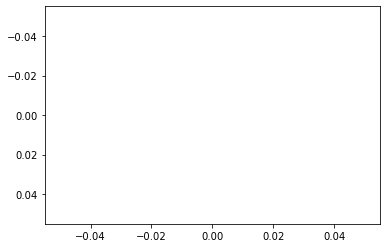

In [71]:
ax = output.unstack(level=0).plot(output.index, output.values, kind='scatter', figsize=(9, 7))
plt.show()

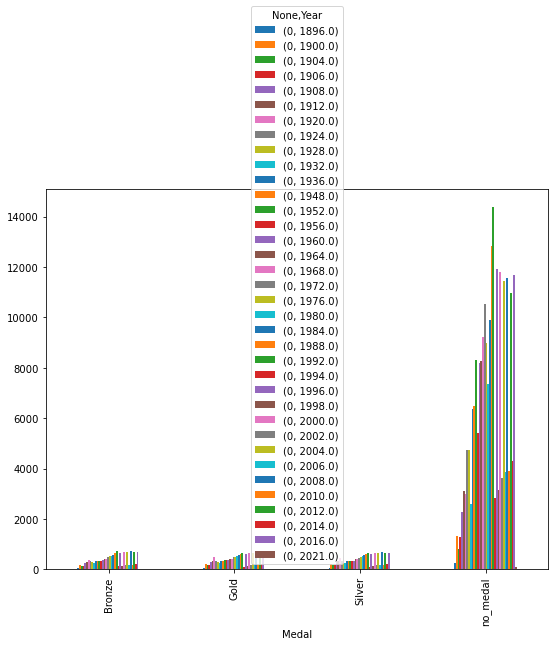

In [48]:
medals_noc_df.sort_values('Year', ascending=True).head(20)

grouped = medals_noc_df.sort_values(['Year'], ascending=False).groupby(['Year','Medal']).size().to_frame()
pd.reset_option('^display.', silent=True)

ax = grouped.unstack(level=0).plot(kind='bar', figsize=(9, 7))
plt.show()